In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one_100, solve_smooth_unreveal, generate_weight
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["lines.linewidth"] = 2.5

In [2]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*μ
ς = 0.1
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.array([0, 2*0.0197, 2*0.3853])
# y grid
numy_bar = 100
y_min = 1e-10
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)

In [3]:
# capital parameters
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0085
κ = 6.667
k0 = 80/α

In [4]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θ_mat = θ_list.reshape(n_temp, n_carb)
θtemp_list = np.average(θ_mat, axis=1)
θcarb_list = np.average(θ_mat, axis=0)

# Jump model of damages
Intensity function:
$$
\mathcal{I}(y) = \begin{cases}
(\frac{1}{\sqrt{2\pi} \varsigma})\exp\left[- \frac{(y - \bar y)^2}{2\varsigma^2}\right], \quad y \leqslant \bar y\\
(\frac{1}{\sqrt{2\pi}\varsigma}), \quad y > \bar y
\end{cases}
$$

HJB
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{\pi^d} &- \delta \phi(y) + \eta \log\tilde e \\
    & +  \frac{d\phi}{dy}\sum_i \pi_i^a\theta_i \tilde e  + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \frac{1}{2} \frac{(\eta - 1)}{\delta}\delta \gamma_2 (\tilde e)^2 |\sigma_y|^2\\
& + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y) \tilde e \sum_i \pi_i^a\theta_i + \mathcal{I}(y)\sum_j \pi^d_j \left[\phi_j(y) - \phi(y) \right] \\
&  + \textbf{relative entropy}
\end{aligned}
$$
## Approach one:
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j} &- \delta \phi(y) +  \eta \log\tilde e + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2  + \frac{\xi_m}{2} h'h\\
& + [ \frac{d\phi}{dy}    + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y)]\cdot \tilde e \sigma_y h +\frac{1}{2}\frac{ (\eta - 1)}{\delta} \gamma_2 (\tilde e)^2 |\sigma_y|^2\\
& + \sum_i \pi_i^c \frac{d\phi}{dy} \theta_i \tilde e  + \sum_i \pi_i^c \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y) \tilde e \theta_i + \xi_a \sum_i \hat\pi^c_i(\log \pi^c_i - \log \hat\pi^c_i)\\
&  + \mathcal{I}(y)\sum_j\hat\pi_j^d g_j\left[\phi_j(y) - \phi(y) \right]  + \xi_m \mathcal{I}(y) \sum_j \hat\pi_j^d [1 - g_j + g_j \log g_j]
\end{aligned}
$$
The optimal $g_j$:
$$
g_j^* = \exp\{\frac{1}{\xi_m}\left( \phi(y) - \phi_j(y)\right)\}
$$
Plug back in
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j} &- \delta \phi(y) + \eta \log\tilde e + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \frac{1}{2}\frac{(\eta -1)}{\delta}\gamma_2(\tilde e)^2 |\sigma_y|^2\\
& + \sum_i \pi_i^c \left[\frac{d\phi}{dy}  + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y)\right] \tilde e \theta_i + \xi_a \sum_i \hat\pi^c_i(\log \pi^c_i - \log \hat\pi^c_i) \\
&  +  \xi_m \mathcal{I}(y) \sum_j \hat\pi_j^d [1 - g_j^* ]
\end{aligned}
$$
Intensity altered to be $\iota^*(y) \mathcal{I} (y)$ where:
$$
\iota^*(y)  = \sum_j \hat\pi_j g_j^* 
$$
Distorted probability:
$$
\pi^*_j  = \frac{\exp\left(-\frac{1}{\xi_m} [\phi_j(y) - \phi(y)] \right) \hat\pi_j}{\iota^*(y)}
$$

In [5]:
def simulate_jump(y_grid, solu, ME,  θ_list, T=100, dt=1):
    ems = solu["ems"]
    πᶜ = solu["πc"]
    πᵈ = solu["πd"]
    ι = solu["ι"]
    h = solu["h"]
    periods = int(T/dt)
    et = np.zeros(periods)
    yt = np.zeros(periods)
    πᶜt = np.zeros((periods, len(θ_list)))
    πᵈt = np.zeros((periods, len(πᵈ)))
    ιt = np.zeros(periods)
    ht = np.zeros(periods)
    if ME is not None:
        me_t = np.zeros(periods)
    # interpolate
    get_πᵈ = interpolate.interp1d(y_grid, πᵈ)
    get_πᶜ = interpolate.interp1d(y_grid, πᶜ)
#     y = np.mean(θ_list)*290
    y =1 
    for t in range(periods):
        if y > np.max(y_grid):
            break
        else:
            ems_point = np.interp(y, y_grid, ems)
            πᵈ_list = get_πᵈ(y)
            πᶜ_list = get_πᶜ(y)
            ι_point = np.interp(y, y_grid, ι)
            h_point = np.interp(y, y_grid, h)
            if ME is not None:
                me_point = np.interp(y, y_grid, ME)
                me_t[t] = me_point
            et[t] = ems_point
            πᵈt[t] = πᵈ_list
            πᶜt[t] = πᶜ_list
            ιt[t] = ι_point
            ht[t] = h_point
            yt[t] = y
            dy = ems_point*np.mean(θ_list)*dt
            y = dy + y
    if ME is not None:
        return yt, et, πᵈt, πᶜt, ιt, ht, me_t
    else:
        return yt, et, πᵈt, πᶜt, ιt, ht

In [6]:
def plot_solu(ht, πᵈt, ϕ_list, solu, args):
    ϕ = solu['φ']
    ξa, ξw, ξp, numy_bar, dmg_weight = args
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
    fig.suptitle(r'$\xi_a = {}, \quad  \xi_w =1/{}, \quad \xi_p = 1/{} $'.format(ξa, int(1/ξw), int(1/ξp)))
    ax1.plot(ht)
    ax1.set_ylim(bottom=0, top=0.3)
    ax1.set_xlim(left=0)
    ax1.set_xlabel('years')
    ax1.set_ylabel('h')
    if np.count_nonzero(dmg_weight) > 2:
        ax2.plot(πᵈt[:,-1][πᵈt[:,-1]>0], label="extreme damage")
    ax2.plot(πᵈt[:,1][πᵈt[:,1]>0], label="high damage")
    ax2.plot(πᵈt[:,0][πᵈt[:,0]>0], label="low damage")
    # ax2.plot(πᵈt[:,2], label="extreme")
    ax2.set_ylim(bottom=0, top=1)
    ax2.set_xlim(left=0)
    ax2.legend()
    ax2.set_xlabel('years')
    ax2.set_ylabel('πᵈ')
    # plot 3
    ϕ_bound = np.average(np.exp(-1/ξp*ϕ_list), axis=0, weights=dmg_weight)
    ϕ_bound = -ξp*np.log(ϕ_bound)
    ax3.plot(y_grid[:numy_bar+1], ϕ, label='prior to jump')
    ax3.plot(y_grid[numy_bar:], ϕ_list[0][numy_bar:], linestyle="--", color="black", label="post jump, low damage")
    ax3.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:], label="post jump, certainty equivalent")
    ax3.plot(y_grid[numy_bar:], ϕ_list[1][numy_bar:], linestyle="-.", color="black", label="post jump, high damage")
    if np.count_nonzero(dmg_weight) > 2:
        ax3.plot(y_grid[numy_bar:], ϕ_list[-1][numy_bar:], linestyle=":", color="black", label="post jump, extreme damage")
    ax3.vlines(x=2, ymin=-11, ymax=5, linestyle="dashed", color="black")
    # ax3.xlim(0,4)
    # ax3.ylim(-0.02, 0.05)
    ax3.set_ylabel('$\phi$')
    ax3.set_xlabel('y')
    ax3.set_xlim(left=0)
    ax3.legend()
    # ax3.set_title(r'$\xi_a = 1,000, \quad  \xi_w =1/400, \quad \xi_p = 1/400 \times 5 $')
    # plt.savefig("phi_x1.pdf", facecolor="w", edgecolor='w', bbox_inches="tight") 

In [7]:
ξa = 1/10_000*100
ξw = 1000*100
ξp = 1/20*100
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args,)

episode: 10000,	 ode error: 0.00012521093323988874,	 ft error: 0.00012840808866580272
episode: 5039,	 ode error: 0.00031751790570883065,	 ft error: 9.980963463126121e-09
episode: 5390,	 ode error: 0.0010988429305889393,	 ft error: 9.980040497718317e-09
episode: 10000,	 ode error: 0.0007220979040502215,	 ft error: 0.0001466729359493139


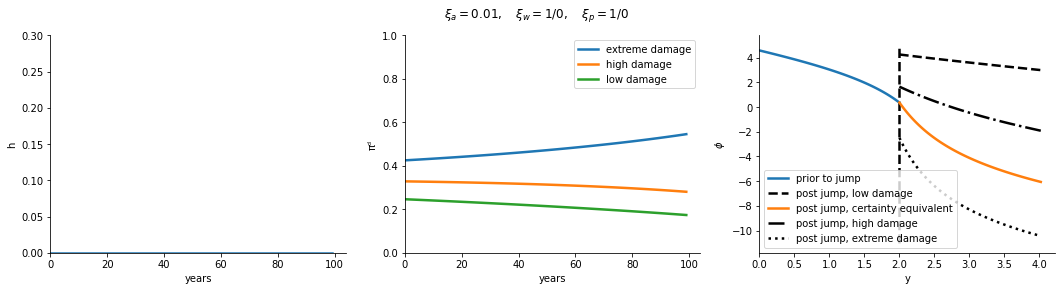

In [8]:
yt, et, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)
args_plot = (ξa, ξw, ξp, numy_bar, dmg_weight)
plot_solu(ht, πᵈt, ϕ_list, solu, args_plot)

(0.0, 6.761061102285348)

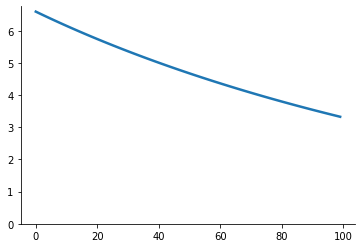

In [9]:
plt.plot(et)
plt.ylim(0)

(0.8, 3.0)

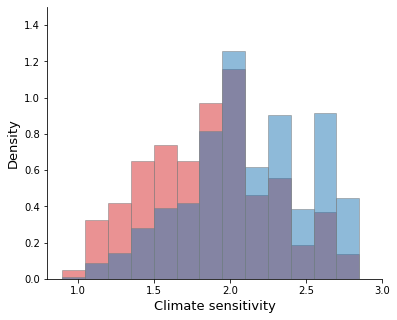

In [10]:
# histogram 10, 50, 90
from matplotlib.ticker import MaxNLocator
fig,ax2 = plt.subplots(1, 1,figsize=(6,5))
# ax1.hist(θ_list*1000, weights=πt_avg[10]*np.exp(-10*δ), density=True, bins=15, color='lightskyblue', ec="grey", alpha=0.8)
# ax1.set_xlabel('Climate sensitivity', fontsize=13)
# ax1.set_ylabel('Distorted density (year 10)', fontsize=13)

# ax1.hist(θ_list*1000, density=True, bins=15, color="salmon", ec="grey", alpha=0.6)
# ax1.set_xlabel('Climate sensitivity', fontsize=13)
# ax1.set_ylabel('Distorted density (year 10)', fontsize=13)
bins = np.linspace(0, 3, 21)

ax2.hist(θ_list*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.5, density=True)
ax2.hist(θ_list*1000, weights=πᶜt[50]*np.exp(-δ*50), bins=bins, color='tab:blue', histtype='bar', ec='gray', alpha=.5, density=True)
ax2.set_xlabel('Climate sensitivity', fontsize=13)
ax2.set_ylabel('Density', fontsize=13)
# ax2.set_title('Mean difference: {:.2f} '.format( (θ_list@πᶜt[50]-np.mean(θ_list) + σy*ht[50])*1000 ) )
ax2.set_ylim(0,1.5)
ax2.set_xticks(np.arange(0,3+0.5, 0.5))
ax2.set_xlim(0.8, 3)
# ax2.hist(θ_list*1000, weights=πᶜt[50]*np.exp(-50*δ), density=True, bins=np.linspace(1,3,14), color="tab:blue", ec="grey", alpha=0.5)
# ax2.set_xlabel('Climate sensitivity', fontsize=13)
# ax2.set_ylabel('Distorted density (year 50)', fontsize=13)
# ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax2.hist(θ_list*1000, density=True, bins=np.linspace(1,3,14), color="tab:red", ec="grey", alpha=0.5)
# ax2.set_xlabel('Climate sensitivity', fontsize=13)
# ax2.set_ylabel('Distorted density (year 50)', fontsize=13)



# ax3.hist(θ_list*1000, weights=πt_avg[90]*np.exp(-90*δ), density=True, bins=15, color="lightskyblue", ec="grey", alpha=0.6)
# ax3.set_xlabel('Climate sensitivity', fontsize=13)
# ax3.set_ylabel('Distorted density (year 90)', fontsize=13)

# ax3.hist(θ_list*1000, density=True, bins=15, color="salmon", ec="grey", alpha=0.6)
# ax3.set_xlabel('Climate sensitivity', fontsize=13)
# ax3.set_ylabel('Distorted density (year 90)', fontsize=13)

# plt.savefig('./paper_plots/histogram_worstcase.pdf')

(0.8, 3.0)

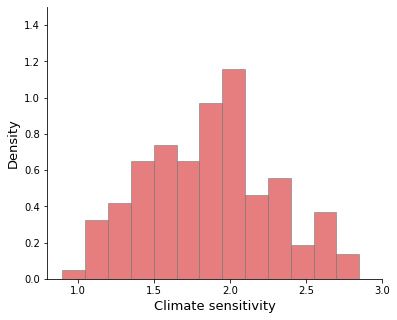

In [11]:
# histogram θ_list
fig,ax2 = plt.subplots(1, 1,figsize=(6,5))
# ax1.hist(θ_list*1000, weights=πt_avg[10]*np.exp(-10*δ), density=True, bins=15, color='lightskyblue', ec="grey", alpha=0.8)
# ax1.set_xlabel('Climate sensitivity', fontsize=13)
# ax1.set_ylabel('Distorted density (year 10)', fontsize=13)

# ax1.hist(θ_list*1000, density=True, bins=15, color="salmon", ec="grey", alpha=0.6)
# ax1.set_xlabel('Climate sensitivity', fontsize=13)
# ax1.set_ylabel('Distorted density (year 10)', fontsize=13)
bins = np.linspace(0, 3, 21)

ax2.hist(θ_list*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.6, density=True)
# ax2.hist(θ_list*1000, weights=πᶜt[50], bins=bins, color='tab:blue', histtype='bar', ec='darkgray', alpha=.5, density=True)
ax2.set_xlabel('Climate sensitivity', fontsize=13)
ax2.set_ylabel('Density', fontsize=13)
# ax2.set_title('Mean difference: {:.2f} '.format( (θ_list@πᶜt[50]-np.mean(θ_list) + σy*ht[50])*1000 ) )
ax2.set_ylim(0,1.5)
ax2.set_xticks(np.arange(0,3+0.5, 0.5))
ax2.set_xlim(0.8, 3)

# plt.savefig('./paper_plots/histogram.pdf')

In [12]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt
def simulate_scc(invkap, αₖ,  σₖ, κ, k0, MEt, T=100, dt=1):
    Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0)
    MCt = δ*(1-η)/((α - invkap)*np.exp(Kt))
    Ct = (α - invkap)*np.exp(Kt)
    SCCt = MEt/MCt*1000
    return SCCt, Ct

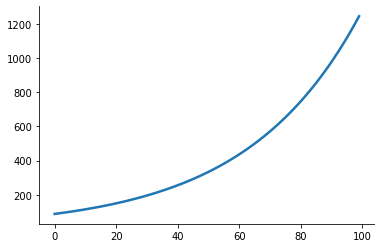

In [13]:
MEt = δ*η/et
SCCt, Ct = simulate_scc(invkap, αₖ,  σₖ, κ, k0, MEt)
plt.plot(SCCt)

In [14]:
ξa = 1/10_000*100
ξw = 1000*100
ξp = 1/20*100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_unreveal, ems_unreveal, π_unreveal = solve_smooth_unreveal(y_grid, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 694,	 ode error: 0.0008695666923007328,	 ft error: 9.965709146797508e-08


In [15]:
def simulate_unreveal(y_grid, ems, π, me, θ_list, T=100, dt=1):
    periods = int(T/dt)
    et = np.zeros(periods)
    yt = np.zeros(periods)
    πt = np.zeros((periods, len(π)))
    me_t = np.zeros(periods)
    get_π = interpolate.interp1d(y_grid, π)
#     y = np.mean(θ_list)*290
    y =1
    for t in range(periods):
        if y > np.max(y_grid):
            break
        else:
            ems_point = np.interp(y, y_grid, ems)
            π_list = get_π(y)
            if me is not None:
                me_point = np.interp(y, y_grid, me)
                me_t[t] = me_point
            et[t] = ems_point
            πt[t] = π_list
            
            yt[t] = y
            dy = ems_point*np.mean(θ_list)*dt
            y = dy + y
    
    return yt, et, πt, me_t

In [16]:
logKt = simulate_logkapital(invkap, αₖ,  σₖ, κ, k0,)

In [17]:
yt_unreveal, et_unreveal, πt_unreveal, _ = simulate_unreveal(y_grid, ems_unreveal, π_unreveal, None, θ_list, T=200)

Text(0.5, 1.0, 'Emission trajectories \n $\\xi_a = 0.01, ξ_p = 5$ for with threshold\n $ξ = 0.01$ for without threshold')

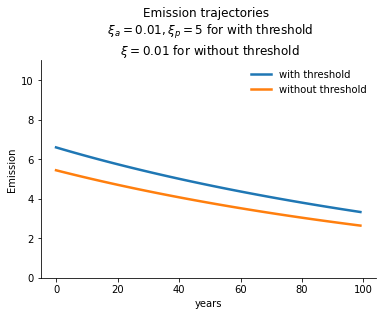

In [18]:
plt.plot(et[et>0], label="with threshold")
plt.plot(et_unreveal[:100], label="without threshold")
plt.ylim(0,11)
plt.legend(frameon=False)
plt.xlabel("years")
plt.ylabel("Emission")
plt.title("Emission trajectories \n $\\xi_a = 0.01, ξ_p = 5$ for with threshold\n $ξ = 0.01$ for without threshold")
# plt.savefig("./paper_plots/ems_nojumpcompare.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 1.0, '$Y_t$ trajectories \n $\\xi_a = 0.01, ξ_p = 5$ for with threshold\n $ξ = 0.01$ for without threshold')

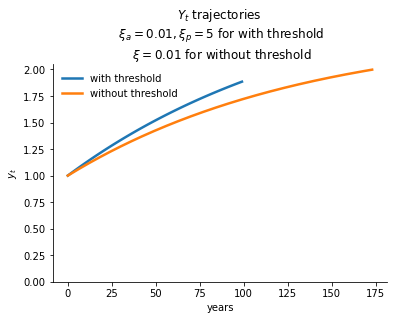

In [19]:
plt.plot(yt[yt>0], label="with threshold")
plt.plot(yt_unreveal[yt_unreveal<=2], label="without threshold")
plt.ylim(0)
plt.legend(frameon=False)
plt.xlabel("years")
plt.ylabel("$y_t$")
plt.title("$Y_t$ trajectories \n $\\xi_a = 0.01, ξ_p = 5$ for with threshold\n $ξ = 0.01$ for without threshold")
# plt.savefig("./paper_plots/ems_nojumpcompare.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 1.0, 'SCC \n $\\xi_a = 0.01, ξ_p = 5$ for with threshold\n $ξ = 0.01$ for without threshold')

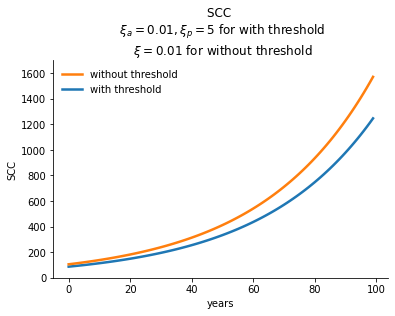

In [20]:
SCCt_unreveal = η*(α - invkap)*np.exp(logKt)/(1-η)/et_unreveal[:100]*1000
plt.plot(SCCt, label="with threshold")
plt.plot(SCCt_unreveal, label="without threshold")
plt.ylim(0,1700)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
plt.xlabel("years")
plt.ylabel("SCC")
plt.title("SCC \n $\\xi_a = 0.01, ξ_p = 5$ for with threshold\n $ξ = 0.01$ for without threshold")
# plt.savefig("./paper_plots/scc_nojumpcompare.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

In [21]:
ξa = 1000*100
ξw = 1000*100
ξp = 1000*100
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args,)
yt_base, et_base, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)

episode: 10000,	 ode error: 0.00011710457906673188,	 ft error: 0.00012173167466637362
episode: 5012,	 ode error: 0.000328243742822254,	 ft error: 9.970615444387931e-09
episode: 5377,	 ode error: 0.0011686487381849346,	 ft error: 9.996075078788635e-09
episode: 1227,	 ode error: 0.000521663011021703,	 ft error: 9.933103228831897e-09


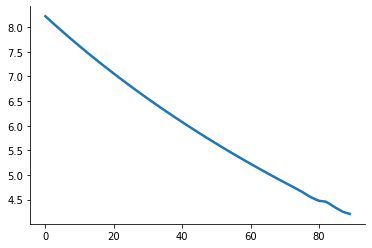

In [28]:
plt.plot(et_base[et_base>0])

In [22]:
ξa = 1000*100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_unreveal_base, ems_unreveal_base, π_unreveal_base = solve_smooth_unreveal(y_grid, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 681,	 ode error: 0.000652568780844253,	 ft error: 9.846339643626578e-08


In [25]:
yt_unreveal_base, et_unreveal_base, πt_unreveal_base, _ = simulate_unreveal(y_grid, ems_unreveal_base, π_unreveal_base, None, θ_list, T=200)

Text(0.5, 1.0, 'Emission trajectories \n $ξ_a = \\infty, ξ_p = \\infty$ for with jump\n $ξ =\\infty$ for without jump')

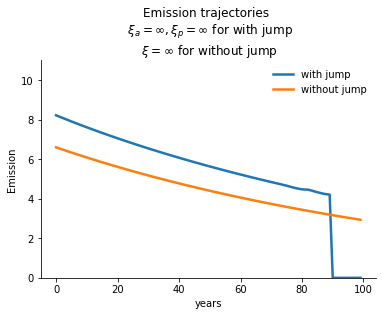

In [26]:
plt.plot(et_base, label="with jump")
plt.plot(et_unreveal_base[:100], label="without jump")
plt.ylim(0,11)
plt.legend(frameon=False)
plt.xlabel("years")
plt.ylabel("Emission")
plt.title("Emission trajectories \n $ξ_a = \infty, ξ_p = \infty$ for with jump\n $ξ =\infty$ for without jump")
# plt.savefig("./paper_plots/ems_nojumpcompare_base.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

<ipython-input-31-e599f94ff8f7>:1: RuntimeWarning: divide by zero encountered in true_divide
  SCCt_base = η*(α - invkap)*np.exp(logKt)/(1-η)/et_base*1000


Text(0.5, 1.0, 'SCC \n $ξ_a = \\infty, ξ_p = \\infty$ for with jump\n $ξ = \\infty$ for without jump')

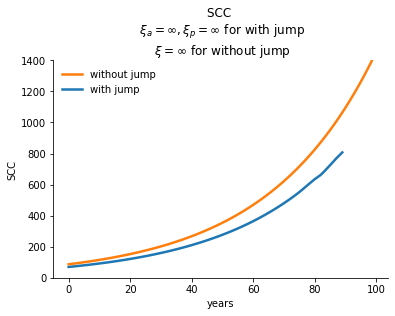

In [31]:
SCCt_base = η*(α - invkap)*np.exp(logKt)/(1-η)/et_base*1000
SCCt_unreveal_base = η*(α - invkap)*np.exp(logKt)/(1-η)/et_unreveal_base[:100]*1000
plt.plot(SCCt_base, label="with jump")
plt.plot(SCCt_unreveal_base, label="without jump")
plt.ylim(0,1400)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
plt.xlabel("years")
plt.ylabel("SCC")
plt.title("SCC \n $ξ_a = \infty, ξ_p = \infty$ for with jump\n $ξ = \infty$ for without jump")
# plt.savefig("./paper_plots/scc_nojumpcompare_base.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

In [33]:
n_climate = len(θ_list)
n_dmg = len(γ3_list)
πc_dict = dict()
for year in [10,50,90, -1]:
    πc_dict[year] = np.sum(πt_unreveal[year].reshape(n_climate, n_dmg), axis=1)

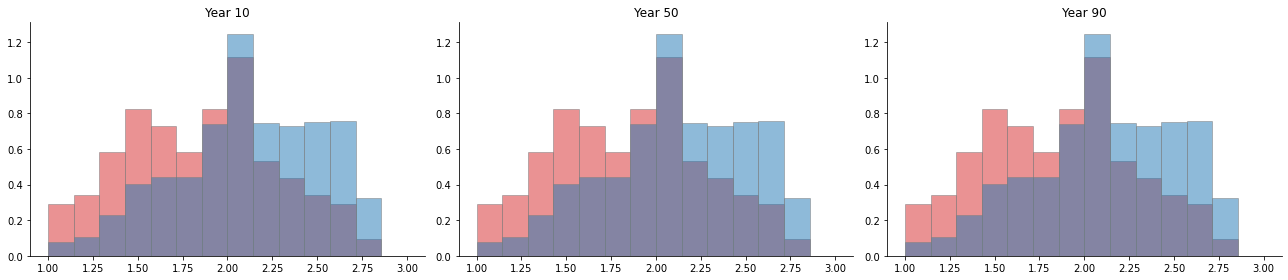

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
axes = [ax1, ax2, ax3]
bins=np.linspace(1,3,15)
ax1.set_title("Year 10")
ax1.hist(θ_list*1000, density=True, bins=bins, alpha=0.5, ec="gray", color="tab:red" )
ax1.hist(θ_list*1000, weights=πc_dict[10], bins=bins, density=True, alpha=0.5, ec="gray", color="tab:blue")

ax2.set_title("Year 50")
ax2.hist(θ_list*1000, density=True, bins=bins, alpha=0.5, ec="gray",color="tab:red" )
ax2.hist(θ_list*1000, weights=πc_dict[50]*np.exp(-50*δ), bins=bins, density=True, alpha=0.5, ec="gray",color="tab:blue")

ax3.set_title("Year 90")
ax3.hist(θ_list*1000, density=True, bins=bins, alpha=0.5, ec="gray", color="tab:red" )
ax3.hist(θ_list*1000, weights=πc_dict[90]*np.exp(-90*δ), bins=bins, density=True, alpha=0.5, ec="gray", color="tab:blue")

fig.tight_layout()
# fig.savefig("./paper_plots/hist_time.png", facecolor="w",dpi=500)

In [35]:
πd_list = np.zeros((200,3))
for year in range(200):
    πd_list[year] = np.sum(πt_unreveal[year].reshape(n_climate, n_dmg), axis=0)

# Decompose  for no jump version

In [36]:
def solve_smooth_unreveal_decompose(y_grid, ems_star, args, max_iter, tol, ϵ,):
    """
    solve for step one, ϕⱼ for individual damage function
    
    Parameter
    ---
    args: δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξa, ξw
    """
    δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw = args
    params = list()
    for θ_i in θ_list:
        for γ3 in γ3_list:
            params.append([θ_i, γ3])
    params = np.array(params)
    θ_long = params[:,0]
    γ3_long = params[:,1]
    args_weight = (δ, η, γ1, γ2, ȳ, σy, ξa)
    dy = y_grid[1] - y_grid[0]
    n_y = len(y_grid)
#     dΛ = γ1 + γ2*y_grid + γ3*(y_grid-ȳ)*(y_grid>ȳ)
#     ddΛ = γ2 + γ3*(y_grid>ȳ)
    ϕ = - η*y_grid**2
    ems = η
    ems_old = ems
    πo = np.ones((len(params), n_y))/len(params)
    lhs_error = 1
    episode = 0
    while lhs_error > tol and episode < max_iter:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy, "up")
        dϕdyy = derivative_1d(ϕ, 2, dy, "up")
#         temp1 = dϕdy + (η-1)/δ*dΛ
#         temp2 = dϕdyy + (de)
        # update belief
        weight = generate_weight(params, ems_star, dϕdy, y_grid, args_weight)
        π = πo*np.exp(weight)
        π[π <= 1e-15] = 1e-15
        π = π/np.sum(π, axis=0)
        # update control
#         temp = dϕdy + (η-1)/δ*(γ1 + γ2*y_grid)
#         ddΛ = γ2 + γ3_long@π*(y_grid>ȳ)
#         a = (dϕdyy  + (η-1)/δ*ddΛ)*σy**2
#         b = (θ_long@π)*temp + (η-1)/δ*((θ_long*γ3_long)@π)*(y_grid - ȳ)*(y_grid>ȳ)
#         c = η
#         Δ = b**2 - 4*a*c
#         Δ[Δ < 0] = 0
#         root1 = (-b - np.sqrt(Δ))/(2*a)
#         root2 = (-b + np.sqrt(Δ))/(2*a)
#         if root1.all() > 0:
#             ems_new = root1
#         else:
#             ems_new = root2
#         ems_new[ems_new < 1e-15] = 1e-15
#         ems = ems_new*0.5 + ems_old*0.5
        # solve for ode
        dmg_drift = θ_long@π*(γ1 + γ2*y_grid)*ems_star + (θ_long*γ3_long)@π*(y_grid-ȳ)*(y_grid>ȳ)*ems_star\
        + 1/2*(γ3_long@π)*(y_grid>ȳ)*σy**2*ems_star**2 + 1/2*γ2*σy**2*ems_star**2
        A = - δ*np.ones(y_grid.shape)
        B = (θ_long@π)*ems_star
#         C = np.zeros(y_grid.shape)
        C = ems_star**2*σy**2/2
        D = η*np.log(ems_star) + ξa*np.sum(π*(np.log(π) - np.log(πo)), axis=0)\
            + (η-1)/δ*dmg_drift
#         - 1/(2*ξw)*temp**2*ems**2*σy**2\
#         + 1/2*(η-1)/δ*ddΛ*ems**2*σy**2
        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
#         ems_old = ems
        episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    me = - θ_long@π*(dϕdy + (η-1)/δ*(γ1 + γ2*y_grid)) - (η-1)/δ*(θ_long*γ3_long)@π*(y_grid-ȳ)*(y_grid>ȳ) \
        - (η-1)/δ*(γ3_long@π)*(y_grid>ȳ)*σy**2*ems_star - (η-1)/δ*γ2*σy**2*ems_star - dϕdyy*σy**2*ems_star
#     h = - temp*ems*σy/ξw
    return ϕ, ems, π, me

In [37]:
ξa = 1/100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_test, ems_test, π_test, me_unreveal = solve_smooth_unreveal_decompose(y_grid, ems_unreveal, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 694,	 ode error: 0.0008695669350341304,	 ft error: 9.959527069725027e-08


In [38]:
ems_10 = 10*np.ones(ems_unreveal.shape)

In [39]:
ems = ems_unreveal
# ems = ems_10

In [44]:
# base
ξa = 1000*100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_b, ems_b, π_b, me_b = solve_smooth_unreveal_decompose(y_grid, ems, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 681,	 ode error: 0.0005883286089622009,	 ft error: 9.537113232482852e-08


In [45]:
# dmamage 
ξa = 1/100
args_unreveal = (δ, η, [np.average(θ_list)], σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_dmg, ems_dmg, π_dmg, me_dmg = solve_smooth_unreveal_decompose(y_grid, ems, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 5000,	 ode error: 0.0007692703380716287,	 ft error: 2.826561062840849e-05


In [46]:
# temp
ξa = 1/100
args_unreveal = (δ, η, θtemp_list, σy, γ1, γ2, [np.average(γ3_list)], ȳ, ξa, ξw)
ϕ_temp, ems_temp, π_temp, me_temp = solve_smooth_unreveal_decompose(y_grid, ems, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 688,	 ode error: 0.0006117452360071673,	 ft error: 9.824843516526016e-08


In [47]:
# carb
ξa = 1/100
args_unreveal = (δ, η, θcarb_list, σy, γ1, γ2, [np.average(γ3_list)], ȳ, ξa, ξw)
ϕ_carb, ems_carb, π_carb, me_carb = solve_smooth_unreveal_decompose(y_grid, ems, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 687,	 ode error: 0.0005965204360334053,	 ft error: 9.99169396109778e-08


In [48]:
# total
ξa = 1/100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_total, ems_total, π_total, me_total = solve_smooth_unreveal_decompose(y_grid, ems, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 694,	 ode error: 0.0008695669350341304,	 ft error: 9.959527069725027e-08


In [49]:
yt_b, et_b, πt_b, met_b = simulate_unreveal(y_grid, ems, π_b, me_b, θ_list, T=200)
yt_dmg, et_dmg, πt_dmg, met_dmg = simulate_unreveal(y_grid, ems, π_dmg, me_dmg, θ_list, T=200)
yt_temp, et_temp, πt_temp, met_temp = simulate_unreveal(y_grid, ems, π_temp, me_temp, θ_list, T=200)
yt_carb, et_carb, πt_carb, met_carb = simulate_unreveal(y_grid, ems, π_carb, me_carb, θ_list, T=200)
yt_total, et_total, πt_total, met_total = simulate_unreveal(y_grid, ems, π_total, me_total, θ_list, T=200)

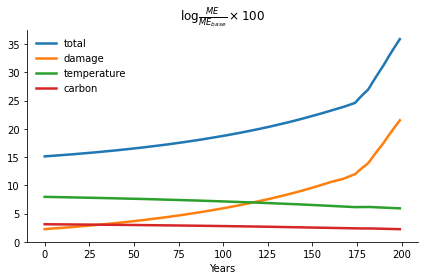

In [50]:
plt.plot(np.log(met_total/met_b)*100, label="total")
plt.plot(np.log(met_dmg/met_b)*100, label="damage")
plt.plot(np.log(met_temp/met_b)*100, label="temperature")
plt.plot(np.log(met_carb/met_b)*100, label="carbon")
plt.ylim(0)
plt.xlabel("Years")
plt.legend(frameon=False)
plt.title("$\\log \\frac{ME}{ME_{base}} \\times 100$")
plt.tight_layout()
# plt.savefig("./paper_plots/decomp_1type_21.png", dpi=500, facecolor="w")

Text(0.5, 1.0, '$\\log \\frac{ME}{ME_{base}} \\times 100$')

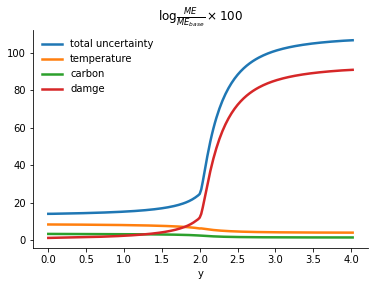

In [51]:
plt.plot(y_grid, np.log(me_total/me_b)*100, label="total uncertainty")
plt.plot(y_grid, np.log(me_temp/me_b)*100, label="temperature")
plt.plot(y_grid, np.log(me_carb/me_b)*100, label="carbon")
plt.plot(y_grid, np.log(me_dmg/me_b)*100, label="damge")
plt.xlabel("y")
plt.legend(frameon=False)
plt.title("$\\log \\frac{ME}{ME_{base}} \\times 100$")

In [52]:
# dmamage and temp
ξa = 1/100
args_unreveal = (δ, η, θtemp_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_tempdmg, ems_tempdmg, π_tempdmg, me_tempdmg = solve_smooth_unreveal_decompose(y_grid, ems, 
                                                                                args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 694,	 ode error: 0.0008360410378625491,	 ft error: 9.874248796393204e-08


In [53]:
# dmamage and carb
ξa = 1/100
args_unreveal = (δ, η, θcarb_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_carbdmg, ems_carbdmg, π_carbdmg, me_carbdmg = solve_smooth_unreveal_decompose(y_grid, ems, 
                                                                                args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 693,	 ode error: 0.0007965239294456961,	 ft error: 9.950145329895577e-08


In [54]:
# temp and carb
ξa = 1/100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, [np.average(γ3_list)], ȳ, ξa, ξw)
ϕ_tempcarb, ems_tempcarb, π_tempcarb, me_tempcarb = solve_smooth_unreveal_decompose(y_grid, ems, 
                                                                                    args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 688,	 ode error: 0.0006244045825355357,	 ft error: 9.841302439639321e-08


In [55]:
yt_carbdmg, et_carbdmg, πt_carbdmg, met_carbdmg = simulate_unreveal(y_grid, ems, π_carbdmg, me_carbdmg, θ_list, T=200)
yt_tempcarb, et_tempcarb, πt_tempcarb, met_tempcarb = simulate_unreveal(y_grid, ems, π_tempcarb, me_tempcarb, θ_list, T=200)
yt_tempdmg, et_tempdmg, πt_tempdmg, met_tempdmg = simulate_unreveal(y_grid, ems, π_tempdmg, me_tempdmg, θ_list, T=200)

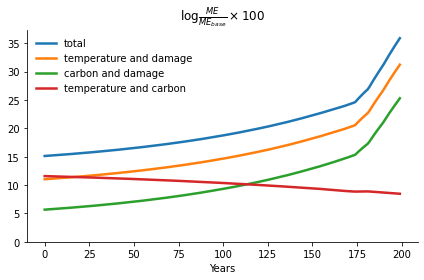

In [56]:
plt.plot(np.log(met_total/met_b)*100, label="total")
plt.plot(np.log(met_tempdmg/met_b)*100, label="temperature and damage")
plt.plot(np.log(met_carbdmg/met_b)*100, label="carbon and damage")
plt.plot(np.log(met_tempcarb/met_b)*100, label="temperature and carbon")
# plt.plot(np.log(met_tempcarb/met_b)*100, label="temperature and carbon"))
plt.ylim(0)
plt.xlabel("Years")
plt.legend(frameon=False)
plt.title("$\\log \\frac{ME}{ME_{base}} \\times 100$")
plt.tight_layout()
# plt.savefig("./paper_plots/decomp_2type_21.png", facecolor="w", dpi=500)

Text(0.5, 1.0, '$\\log \\frac{ME}{ME_{base}} \\times 100$')

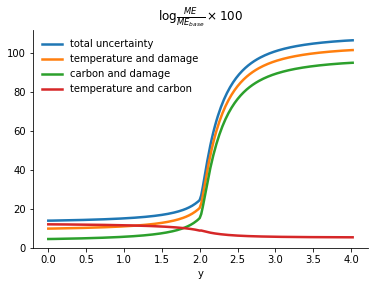

In [57]:
plt.plot(y_grid, np.log(me_total/me_b)*100, label="total uncertainty")
plt.plot(y_grid, np.log(me_tempdmg/me_b)*100, label="temperature and damage")
plt.plot(y_grid, np.log(me_carbdmg/me_b)*100, label="carbon and damage")
plt.plot(y_grid, np.log(me_tempcarb/me_b)*100, label="temperature and carbon")
plt.xlabel("y")
plt.ylim(0)
plt.legend(frameon=False)
plt.title("$\\log \\frac{ME}{ME_{base}} \\times 100$")

# SCC uncertainty decomposition: pre jump

First order condition for $\tilde e$

$$
    \left( \frac{d^2\phi(y)}{dy^2} + \frac{(\eta-1)}{\delta}\cdot\gamma_2  \right)|\sigma_y|^2\tilde e + \sum_j \pi^c_j \left[\frac{d\phi(y)}{dy} + \frac{(\eta - 1)}{\delta}(\gamma_1 + \gamma_2 y)\right]\theta_j  + \frac{\eta}{\tilde e} = 0 \tag{$\ast$}
$$

Call solution $\tilde e^* $. Now solve:
$$
\begin{aligned}
0 =  & - \delta \color{red}{\phi(y)}+ \eta \log\tilde e^* + \frac{1}{2} \color{red}{ \frac{d^2 \phi}{dy^2}}\cdot(\tilde e^*)^2 |\sigma_y|^2 + \frac{1}{2}\frac{(\eta -1)}{\delta}\gamma_2(\tilde e^*)^2 |\sigma_y|^2\\
& + \left[\color{red}{\frac{d\phi}{dy}}  + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y)\right] \tilde e^* \sum_i \pi_i^c \theta_i
\end{aligned}
$$

In [58]:
def plot_together(et, θ_list, ht, πᶜt, πᵈt, MEt, dmg_weight):
    y_grid_cap = y_grid[:numy_bar+1]
    πᶜo = πᶜo = np.ones(len(θ_list))/len(θ_list)
    # plot
    fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,8))
    fig.tight_layout(pad=5)
    # plot 1
    if np.count_nonzero(dmg_weight) > 2:
        ax1.plot(πᵈt[:,-1], label="extreme damage", color="C2")
    ax1.plot(πᵈt[:,1], label="high damage", color="C3")
    ax1.plot(πᵈt[:,0], label="low", color="C0")
    ax1.legend(frameon=False)
    ax1.set_xlabel('Years')
    ax1.set_ylim(0,1)
    ax1.set_xlim(left=0)
    ax1.set_title('distorted probability of damage')
    # plot 2
    bins = np.linspace(1,3,14)
    ax2.hist(θ_list*1000, density=True, color='tab:red', bins=bins, histtype='bar', ec='gray', alpha=.5, )
    ax2.hist((θ_list+σy*ht[49])*1000, weights=πᶜt[49], density=True, color='tab:blue',bins=bins, histtype='bar', ec='gray', alpha=.5,)
    ax2.set_title('mean difference: {:.4f}'.format((θ_list@(πᶜt[49]-πᶜo)+σy*ht[49])*1000))
    ax2.set_xlabel('Climate sensitivity, year 50')
    ax2.set_xlim(0.8,3)
    # plot 3
    ax3.plot(et[et_base>0],label='distorted', color="C3")
    ax3.plot(et_base[et_base>0], label="baseline", color="C0")
    ax3.legend(frameon=False)
    ax3.set_xlabel('Years')
    ax3.set_ylim(bottom=0)
    ax3.set_xlim(left=0)
    ax3.set_title('emission')
    # plot 4
    SCCt_base, _ = simulate_scc(invkap, αₖ,  σₖ, κ, k0, MEt)
    SCCt_distorted, _ = simulate_scc(invkap, αₖ,  σₖ, κ, k0, δ*η/et)
#     ax4.plot((δ*η/et[et>0])/MC[et>0]*1000, label="total", color="C3")
    ax4.plot(SCCt_distorted, label="total", color="C3")
#     ax4.plot((ME/MC)[et>0]*1000, label="baseline", color="C0")
    ax4.plot(SCCt_distorted - SCCt_base, label="baseline", color="C0")
    ax4.legend(frameon=False)
    ax4.set_xlabel('Years')
    ax4.set_ylim(bottom=0)
    ax4.set_xlim(left=0)
    ax4.set_title('social cost of carbon')
    
    return fig, ((ax1, ax2), (ax3, ax4))

In [59]:
def simulate_jump_ems(y_grid, solu, ME,  θ_list, T=100, dt=1):
    ems = solu["ems"]
    πᶜ = solu["πc"]
    πᵈ = solu["πd"]
    ι = solu["ι"]
    h = solu["h"]
    periods = int(T/dt)
    et = np.zeros(periods)
    yt = np.zeros(periods)
    πᶜt = np.zeros((periods, len(θ_list)))
    πᵈt = np.zeros((periods, len(πᵈ)))
    ιt = np.zeros(periods)
    ht = np.zeros(periods)
    if ME is not None:
        me_t = np.zeros(periods)
    # interpolate
    get_πᵈ = interpolate.interp1d(y_grid, πᵈ)
    get_πᶜ = interpolate.interp1d(y_grid, πᶜ)
#     y = np.mean(θ_list)*290
    y=1
    for t in range(periods):
        if y > np.max(y_grid):
            break
        else:
            ems_point = np.interp(y, y_grid, ems)
            πᵈ_list = get_πᵈ(y)
            πᶜ_list = get_πᶜ(y)
            ι_point = np.interp(y, y_grid, ι)
            h_point = np.interp(y, y_grid, h)
            if ME is not None:
                me_point = np.interp(y, y_grid, ME)
                me_t[t] = me_point
            et[t] = ems_point
            πᵈt[t] = πᵈ_list
            πᶜt[t] = πᶜ_list
            ιt[t] = ι_point
            ht[t] = h_point
            yt[t] = y
            dy = ems_point*(θ_list@πᶜ_list + σy*h_point)*dt
            y = dy + y
    if ME is not None:
        return yt, et, πᵈt, πᶜt, ιt, ht, me_t
    else:
        return yt, et, πᵈt, πᶜt, ιt, ht

In [60]:
ξa = 100000
ξw = 100000
ξp = 100000
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args)
yt_bb, et_bb, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)
yt_bbw, et_bbw, πᵈt, πᶜt, ιt, ht = simulate_jump_ems(y_grid[:numy_bar+1], solu, None, θ_list)

episode: 10000,	 ode error: 0.00011710457906673188,	 ft error: 0.00012173167466637362
episode: 5012,	 ode error: 0.000328243742822254,	 ft error: 9.970615444387931e-09
episode: 5377,	 ode error: 0.0011686487381849346,	 ft error: 9.996075078788635e-09
episode: 1227,	 ode error: 0.000521663011021703,	 ft error: 9.933103228831897e-09


In [61]:
ξa = 100000
ξw = 0.3
ξp = 5
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, max_iter=5_000)
yt_3, et_3, πᵈt, πᶜt_3, ιt, ht_3 = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)
yt_3w, et_3w, πᵈt, πᶜt_3, ιt, ht_3w = simulate_jump_ems(y_grid[:numy_bar+1], solu, None, θ_list)

episode: 5000,	 ode error: 0.0005104346301074425,	 ft error: 2.3678546477630867e-05
episode: 5000,	 ode error: 0.00023846874503928583,	 ft error: 0.00010943308729268372
episode: 5000,	 ode error: 0.000987460360670117,	 ft error: 3.1945338226554064e-08
episode: 1474,	 ode error: 0.0006519126084000362,	 ft error: 9.824745461628481e-09


In [62]:
# adding equal version 1 
ξa = 100000
ξw = 0.3
ξp = 0.3
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, ϵ=2, max_iter=5_000)
yt_e1, et_e1, πᵈt, πᶜt, ιt, ht_e1 = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)
yt_e1w, et_e1w, πᵈt, πᶜt, ιt, ht_e1w = simulate_jump_ems(y_grid[:numy_bar+1], solu, None, θ_list)

episode: 5000,	 ode error: 5.814652399450948e-05,	 ft error: 1.9997413803984898e-05
episode: 760,	 ode error: 0.0002837755205893633,	 ft error: 9.97730731366886e-09
episode: 817,	 ode error: 0.0009680955968403412,	 ft error: 9.804258738199678e-09
episode: 5000,	 ode error: 0.001879725126314011,	 ft error: 6.641312343402817e-07


In [63]:
# adding equal version 2
ξa = 1000*100
ξw = 1/20*100
ξp = 1/20*100
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, ϵ=2, max_iter=5_000)
yt_e2, et_e2, πᵈt, πᶜt, ιt, ht_e2 = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)
yt_e2w, et_e2w, πᵈt, πᶜt, ιt, ht_e2w = simulate_jump_ems(y_grid[:numy_bar+1], solu, None, θ_list)

episode: 3177,	 ode error: 8.894208216329857e-05,	 ft error: 9.778538423432792e-09
episode: 5000,	 ode error: 0.000241901747241903,	 ft error: 5.0170904475344e-05
episode: 814,	 ode error: 0.0010729152681469697,	 ft error: 9.739547834897166e-09
episode: 5000,	 ode error: 0.0007893408641111016,	 ft error: 4.773217333498003e-06


Text(0.5, 0, 'Years')

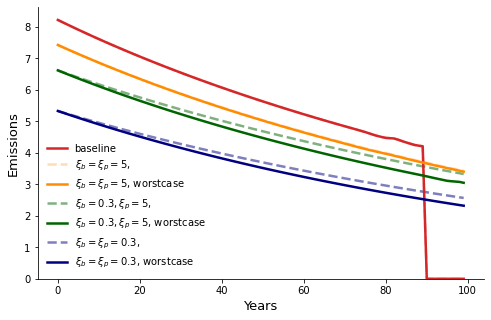

In [64]:
#
fig = plt.figure(figsize=(8,5))
plt.plot(et_bb, label="baseline", color="tab:red", alpha=0.3, linestyle="dashed")
plt.plot(et_e2, label="$ξ_b = ξ_p = 5$,", color="darkorange", alpha=0.3, linestyle="dashed")
# plt.plot(et_brownian, label="brownian robust, jump robust", color="tab:blue")
# plt.plot(et_smooth, label="smooth ambiguity, jump robust", color="darkgreen")
plt.plot(et_3, label="$ξ_b =0.3,  ξ_p = 5$,", color="darkgreen", alpha=0.5, linestyle="dashed")
plt.plot(et_e1, label="$ξ_b = ξ_p = 0.3$, " , color="navy", alpha=0.5, linestyle="dashed")


plt.plot(et_bbw, label="baseline", color="tab:red")
plt.plot(et_e2w, label="$ξ_b = ξ_p = 5$, worstcase", color="darkorange")
# plt.plot(et_brownian, label="brownian robust, jump robust", color="tab:blue")
# plt.plot(et_smooth, label="smooth ambiguity, jump robust", color="darkgreen")
plt.plot(et_3w, label="$ξ_b =0.3,  ξ_p = 5$, worstcase", color="darkgreen")
plt.plot(et_e1w, label="$ξ_b = ξ_p = 0.3$, worstcase" , color="navy")


# plt.plot(et, label="with drift term + jump robust")
handles, labels = plt.gca().get_legend_handles_labels()
order = [4,1,5,2,6,3,7,]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False, loc=3)
# plt.legend(frameon=False, loc=3)
plt.ylim(0)
plt.ylabel('Emissions', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.savefig("./paper_plots/emission_three.pdf")
# plt.savefig("./paper_plots/emission.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 0, 'Years')

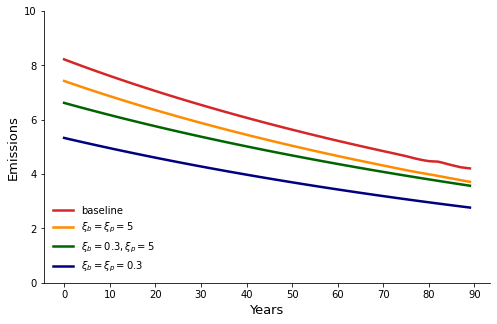

In [86]:
#
fig = plt.figure(figsize=(8,5))
plt.plot(et_bb[et_bb>0], label="baseline", color="tab:red")
plt.plot(et_e2[et_bb>0], label="$ξ_b = ξ_p = 5$", color="darkorange")
# plt.plot(et_brownian, label="brownian robust, jump robust", color="tab:blue")
# plt.plot(et_smooth, label="smooth ambiguity, jump robust", color="darkgreen")
plt.plot(et_3[et_bb>0], label="$ξ_b =0.3,  ξ_p = 5$", color="darkgreen")
plt.plot(et_e1[et_bb>0], label="$ξ_b = ξ_p = 0.3$" , color="navy")

# plt.plot(et, label="with drift term + jump robust")
plt.legend(frameon=False, loc=3)
plt.ylim(0,10)
# plt.xlim(right=95)
plt.xticks(np.arange(0, 91, 10))
plt.ylabel('Emissions', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.savefig("./paper_plots/emission_three.pdf")
# plt.savefig("./paper_plots/emission_five.png", facecolor="w", edgecolor="w", bbox_inches="tight")

<ipython-input-85-649ea1dfe099>:11: RuntimeWarning: divide by zero encountered in log
  plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_bb*γ1 + γ2/2*yt_bb**2) -np.log(et_bb) + np.log(η) - np.log(1- η), label="baseline", color="tab:red")


Text(0.5, 0, 'Years')

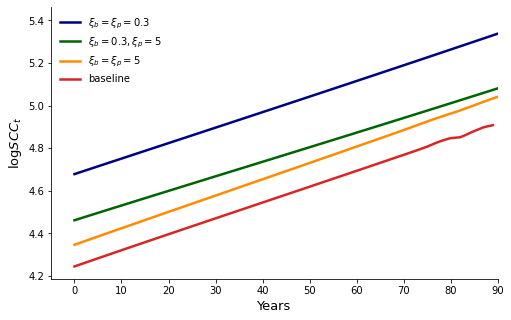

In [85]:
#
fig = plt.figure(figsize=(8,5))
# plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_browian*γ1 + γ2/2*yt_browian**2) - np.log(et_brownian) + np.log(η) - np.log(1 -η), label="brownian robust, jump robust", color="tab:blue")
# plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_smooth*γ1 + γ2/2*yt_smooth**2) - np.log(et_smooth) + np.log(η) - np.log(1 -η), label="smooth ambiguity, jump robust", color="darkgreen")


plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_e1*γ1 + γ2/2*yt_e1**2) -np.log(et_e1) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 0.3$", color="navy")
plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_3*γ1 + γ2/2*yt_3**2) -np.log(et_3) + np.log(η) - np.log(1- η), label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen")
# plt.plot( np.log(1000) - np.log(et) + np.log(η) - np.log(1 -η), label="with drift term + jump robust")
plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_e2*γ1 + γ2/2*yt_e2**2) -np.log(et_e2) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 5$", color="darkorange")
plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_bb*γ1 + γ2/2*yt_bb**2) -np.log(et_bb) + np.log(η) - np.log(1- η), label="baseline", color="tab:red")
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
# plt.ylim(0)
plt.xticks(np.arange(0,91,10))
plt.xlim(right=90)
plt.ylabel('$\log SCC_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("./paper_plots/logscc.pdf")
# plt.savefig("./paper_plots/logscc_five.png", facecolor="w", edgecolor="w", bbox_inches="tight")

<ipython-input-87-1f84efefefe7>:8: RuntimeWarning: divide by zero encountered in log
  plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_bb*γ1 + γ2/2*yt_bb**2) -np.log(et_bb) + np.log(η) - np.log(1- η), label="baseline, baseline", color="tab:red", alpha=0.5, linestyle="dashed")
<ipython-input-87-1f84efefefe7>:14: RuntimeWarning: divide by zero encountered in log
  plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_bbw*γ1 + γ2/2*yt_bbw**2) -np.log(et_bbw) + np.log(η) - np.log(1- η), label="baseline", color="tab:red")


Text(0.5, 0, 'Years')

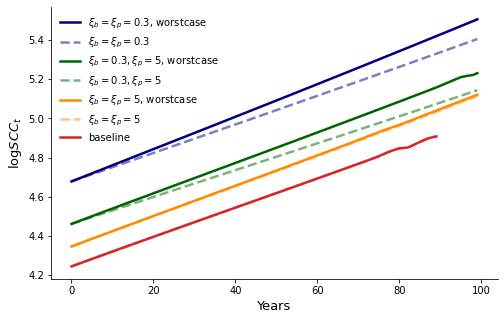

In [87]:
#
fig = plt.figure(figsize=(8,5))

plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_e1*γ1 + γ2/2*yt_e1**2) -np.log(et_e1) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 0.3$", color="navy", alpha=0.5, linestyle="dashed")
plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_3*γ1 + γ2/2*yt_3**2) -np.log(et_3) + np.log(η) - np.log(1- η), label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen", alpha=0.5, linestyle="dashed")
# plt.plot( np.log(1000) - np.log(et) + np.log(η) - np.log(1 -η), label="with drift term + jump robust")
plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_e2*γ1 + γ2/2*yt_e2**2) -np.log(et_e2) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 5$", color="darkorange", alpha=0.5, linestyle="dashed")
plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_bb*γ1 + γ2/2*yt_bb**2) -np.log(et_bb) + np.log(η) - np.log(1- η), label="baseline, baseline", color="tab:red", alpha=0.5, linestyle="dashed")

plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_e1w*γ1 + γ2/2*yt_e1w**2) -np.log(et_e1w) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 0.3$, worstcase", color="navy")
plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_3w*γ1 + γ2/2*yt_3w**2) -np.log(et_3w) + np.log(η) - np.log(1- η), label="$ξ_b =0.3, ξ_p = 5$, worstcase", color="darkgreen")
# plt.plot( np.log(1000) - np.log(et) + np.log(η) - np.log(1 -η), label="with drift term + jump robust")
plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_e2w*γ1 + γ2/2*yt_e2w**2) -np.log(et_e2w) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 5$, worstcase", color="darkorange")
plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_bbw*γ1 + γ2/2*yt_bbw**2) -np.log(et_bbw) + np.log(η) - np.log(1- η), label="baseline", color="tab:red")
handles, labels = plt.gca().get_legend_handles_labels()
order = [4,0,5,1,6,2,7,]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
# plt.ylim(0)
plt.ylabel('$\log SCC_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("./paper_plots/logscc.pdf")
# plt.savefig("./paper_plots/logscc.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 0, 'Years')

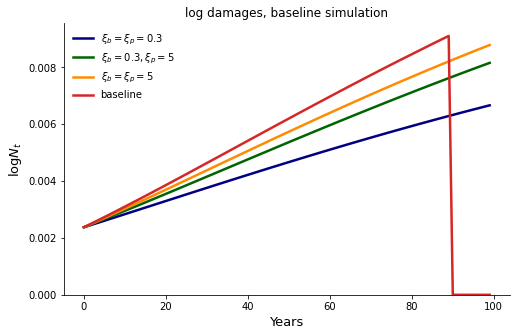

In [88]:
# log damage, baseline
fig = plt.figure(figsize=(8,5))
# plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_browian*γ1 + γ2/2*yt_browian**2) - np.log(et_brownian) + np.log(η) - np.log(1 -η), label="brownian robust, jump robust", color="tab:blue")
# plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_smooth*γ1 + γ2/2*yt_smooth**2) - np.log(et_smooth) + np.log(η) - np.log(1 -η), label="smooth ambiguity, jump robust", color="darkgreen")


plt.plot( (yt_e1*γ1 + γ2/2*yt_e1**2), label="$ξ_b = ξ_p = 0.3$", color="navy")
plt.plot(  (yt_3*γ1 + γ2/2*yt_3**2) , label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen")
# plt.plot( np.log(1000) - np.log(et) + np.log(η) - np.log(1 -η), label="with drift term + jump robust")
plt.plot(  (yt_e2*γ1 + γ2/2*yt_e2**2) , label="$ξ_b = ξ_p = 5$", color="darkorange")
plt.plot(  (yt_bb*γ1 + γ2/2*yt_bb**2) , label="baseline", color="tab:red")
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
plt.ylim(0)
plt.title("log damages, baseline simulation")
plt.ylabel('$\log N_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("./paper_plots/logscc.pdf")
# plt.savefig("./paper_plots/logn_baseline.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 0, 'Years')

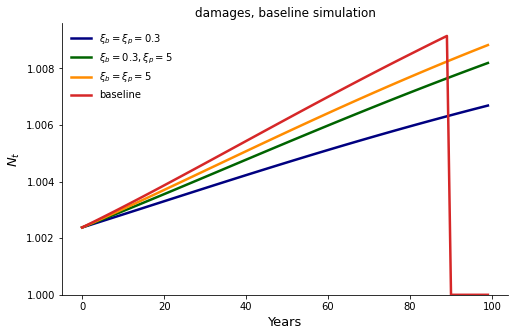

In [89]:
# damages,baseline simulation
fig = plt.figure(figsize=(8,5))
plt.plot(np.exp(yt_e1*γ1 + γ2/2*yt_e1**2), label="$ξ_b = ξ_p = 0.3$", color="navy")
plt.plot( np.exp(yt_3*γ1 + γ2/2*yt_3**2) , label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen")
# plt.plot( np.log(1000) - np.log(et) + np.log(η) - np.log(1 -η), label="with drift term + jump robust")
plt.plot(  np.exp(yt_e2*γ1 + γ2/2*yt_e2**2) , label="$ξ_b = ξ_p = 5$", color="darkorange")
plt.plot(  np.exp(yt_bb*γ1 + γ2/2*yt_bb**2) , label="baseline", color="tab:red")
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
plt.ylim(1)
plt.title("damages, baseline simulation")
plt.ylabel('$N_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("./paper_plots/logscc.pdf")
# plt.savefig("./paper_plots/n_baseline.png",dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 0, 'Years')

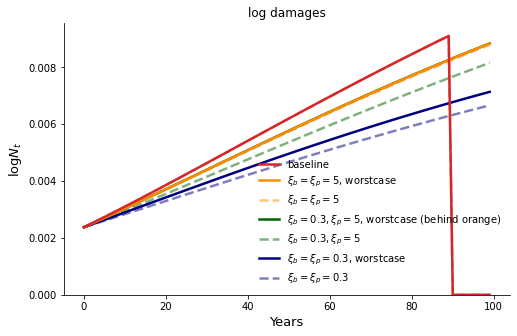

In [90]:
# log damages, worstcase
fig = plt.figure(figsize=(8,5))

plt.plot( (yt_e1*γ1 + γ2/2*yt_e1**2), label="$ξ_b = ξ_p = 0.3$", color="navy", alpha=0.5, linestyle="dashed")
plt.plot(  (yt_3*γ1 + γ2/2*yt_3**2) , label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen", alpha=0.5, linestyle="dashed")
plt.plot(  (yt_e2*γ1 + γ2/2*yt_e2**2) , label="$ξ_b = ξ_p = 5$", color="darkorange", alpha=0.5, linestyle="dashed")
plt.plot(  (yt_bb*γ1 + γ2/2*yt_bb**2) , label="baseline", color="tab:red", alpha=0.5, linestyle="dashed")

plt.plot( (yt_e1w*γ1 + γ2/2*yt_e1w**2), label="$ξ_b = ξ_p = 0.3$, worstcase", color="navy")
plt.plot(  (yt_3w*γ1 + γ2/2*yt_3w**2) , label="$ξ_b =0.3, ξ_p = 5$, worstcase (behind orange)", color="darkgreen")
plt.plot(  (yt_e2w*γ1 + γ2/2*yt_e2w**2) , label="$ξ_b = ξ_p = 5$, worstcase", color="darkorange")
plt.plot(  (yt_bbw*γ1 + γ2/2*yt_bbw**2) , label="baseline", color="tab:red")
handles, labels = plt.gca().get_legend_handles_labels()
order = [7,6,2, 5, 1, 4,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
plt.ylim(0)
plt.title("log damages")
plt.ylabel('$\log N_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("./paper_plots/logscc.pdf")
# plt.savefig("./paper_plots/logn.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 0, 'Years')

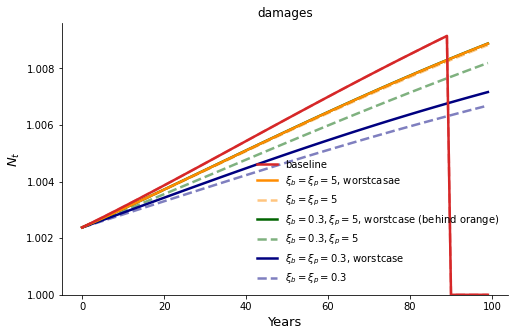

In [91]:
# damages, worstcase simulation
fig = plt.figure(figsize=(8,5))
plt.plot(np.exp(yt_e1*γ1 + γ2/2*yt_e1**2), label="$ξ_b = ξ_p = 0.3$", color="navy", alpha=0.5, linestyle="dashed")
plt.plot( np.exp(yt_3*γ1 + γ2/2*yt_3**2) , label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen", alpha=0.5, linestyle="dashed")
plt.plot(  np.exp(yt_e2*γ1 + γ2/2*yt_e2**2) , label="$ξ_b = ξ_p = 5$", color="darkorange", alpha=0.5, linestyle="dashed")
plt.plot(  np.exp(yt_bb*γ1 + γ2/2*yt_bb**2) , label="baseline", color="tab:red", alpha=0.5, linestyle="dashed")

plt.plot(np.exp(yt_e1w*γ1 + γ2/2*yt_e1w**2), label="$ξ_b = ξ_p = 0.3$, worstcase", color="navy")
plt.plot( np.exp(yt_3w*γ1 + γ2/2*yt_3w**2) , label="$ξ_b =0.3, ξ_p = 5$, worstcase (behind orange)", color="darkgreen")
plt.plot(  np.exp(yt_e2w*γ1 + γ2/2*yt_e2w**2) , label="$ξ_b = ξ_p = 5$, worstcasae", color="darkorange")
plt.plot(  np.exp(yt_bbw*γ1 + γ2/2*yt_bbw**2) , label="baseline", color="tab:red")
handles, labels = plt.gca().get_legend_handles_labels()
order = [7,6,2, 5, 1, 4,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
plt.ylim(1)
plt.title("damages")
plt.ylabel('$N_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("./paper_plots/logscc.pdf")
# plt.savefig("./paper_plots/n.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

<ipython-input-92-a1531639c577>:1: RuntimeWarning: divide by zero encountered in true_divide
  me = δ*η/et_bb


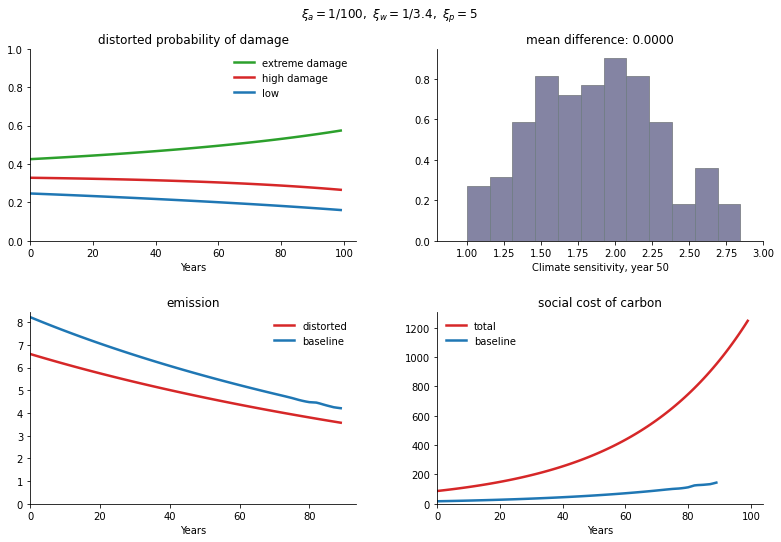

In [92]:
me = δ*η/et_bb
et_base = et_bb
fig, ((ax1, ax2), (ax3, ax4)) = plot_together(et,  θ_list, ht, πᶜt, πᵈt, me, dmg_weight)
fig.suptitle("$ξ_a = 1/100,\ ξ_w = 1/3.4,\ ξ_p =  5$")
# plt.savefig('15_600_1.pdf')
plt.show()